In [129]:
import os
import astropy.coordinates as coord
import astropy.table as at
import astropy.units as u
from astropy.io import fits
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd
import yaml

from hq.config import HQ_CACHE_PATH, config_to_alldata, config_to_jokerparams
from hq.plot import plot_two_panel, plot_phase_fold
from hq.data import get_rvdata
from hq.physics_helpers import period_at_surface, stellar_radius
from hq.mass_helpers import get_martig_mass

from thejoker.plot import plot_rv_curves
from thejoker import JokerSamples, JokerParams, TheJoker

from twobody.transforms import get_m2_min

from turbo import turbo, turbo_r

In [3]:
name = 'dr16-Kprior'

In [8]:
with open(f"{HQ_CACHE_PATH}/{name}/config.yml", "r") as f:
    config = yaml.load(f.read())
    
allstar, allvisit = config_to_alldata(config)
poly_trend = config['hyperparams']['poly_trend']

master = at.QTable.read(f"{HQ_CACHE_PATH}/{name}/metadata-master.fits")
master = at.join(master, allstar, keys='APOGEE_ID')

In [106]:
full_allvisit = fits.getdata(os.path.expanduser(config['data']['allvisit']))
_, all_nvisits = np.unique(full_allvisit['APOGEE_ID'], return_counts=True)

In [136]:
df = pd.DataFrame({'APOGEE_ID': full_allvisit['APOGEE_ID'],
                   'JD': full_allvisit['JD'].astype('<f8')})
g = df.groupby('APOGEE_ID')
all_baseline = g['JD'].agg(np.ptp)

In [14]:
baseline = np.array(master['MAP_P'].value * master['periods_spanned']) * u.day

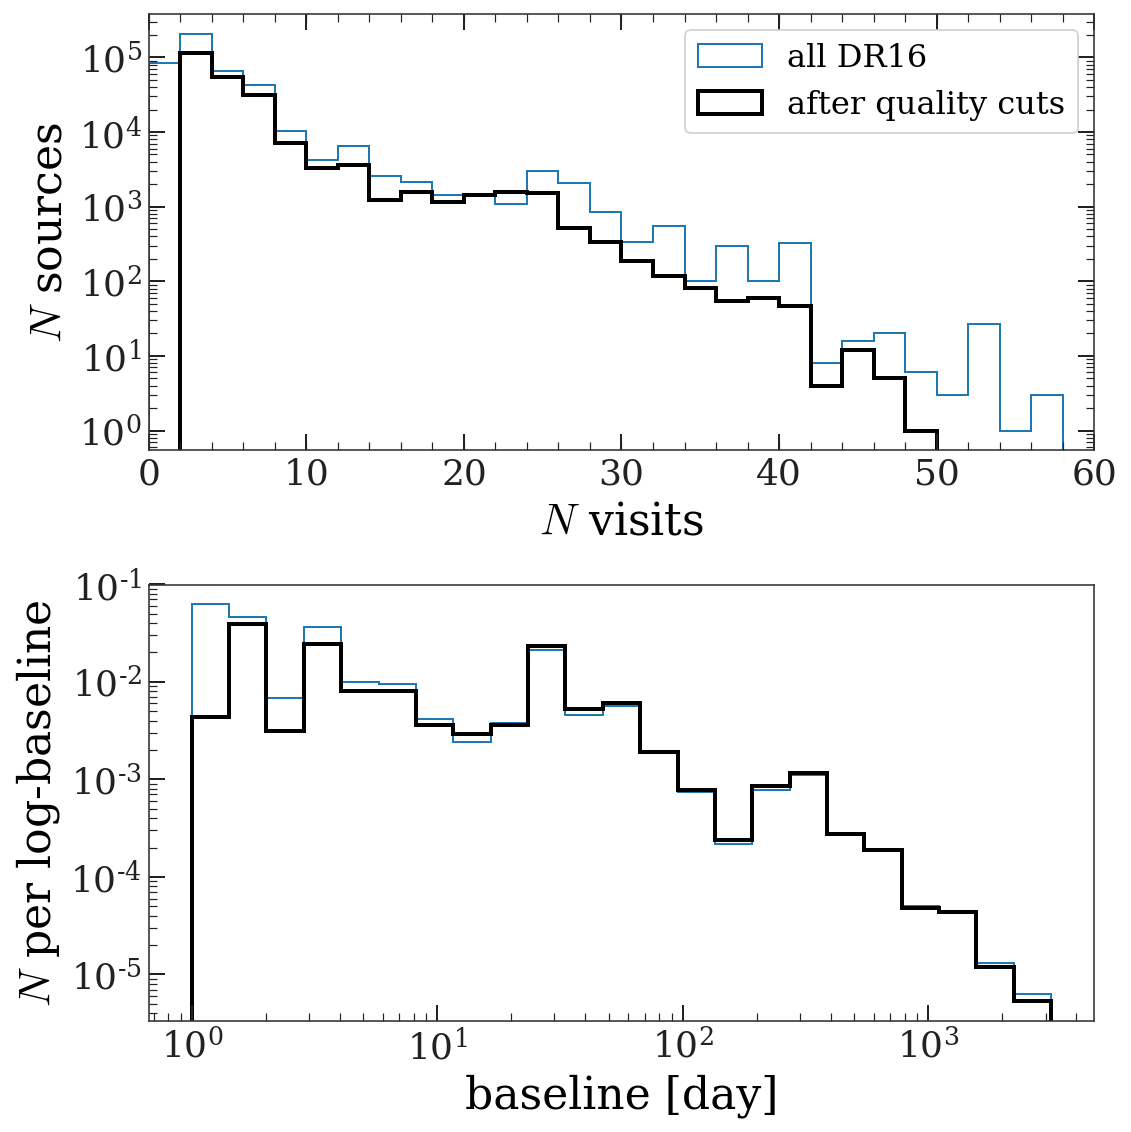

In [147]:
all_style = dict(histtype='step', color='tab:blue', linewidth=1)
apw_style = dict(histtype='step', color='k', linewidth=2)

fig, axes = plt.subplots(2, 1, figsize=(8, 8))

ax = axes[0]
# bins = np.logspace(0, 1.8, 24)
bins = np.arange(0, 60+1e-3, 2)
ax.hist(all_nvisits, bins=bins, label='all DR16',
        **all_style)
ax.hist(master['n_visits'], bins=bins, label='after quality cuts',
        **apw_style)
# ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlim(0, 60)
ax.xaxis.set_ticks(np.arange(0, ax.get_xlim()[1], 2), minor=True)
ax.tick_params(bottom=True, top=True, left=True, right=True, which='both')
ax.legend(loc='upper right', fontsize=16)

ax.set_xlabel('$N$ visits')
ax.set_ylabel('$N$ sources')

# ------------------------------------------------------------

ax = axes[1]

bins = np.logspace(0, 3.5, 24, base=10)
# H, xe = np.histogram(baseline, bins=bins)
# V = xe[1:] - xe[:-1]
# ctr = 0.5 * (xe[:-1] + xe[1:])
# ax.plot(ctr, H/V)
ax.hist(all_baseline, bins=bins, density=True,
        **all_style)
ax.hist(baseline, bins=bins, density=True,
        **apw_style)

ax.set_xscale('log') #, basex=2)
ax.set_yscale('log')
# ax.set_xlim(2, 60)

ax.set_xlabel('baseline [day]')
ax.set_ylabel('$N$ per log-baseline')

fig.tight_layout()

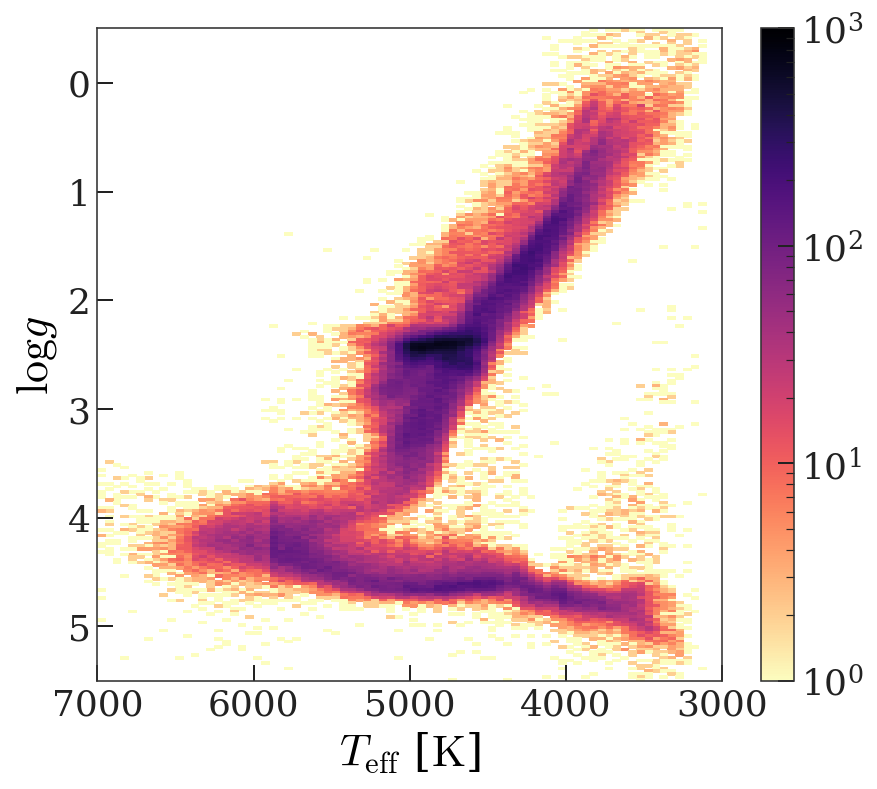

In [81]:
fig, ax = plt.subplots(1, 1, figsize=(7, 6))

xlim = (3000, 7000)
ylim = (-0.5, 5.5)
H, xe, ye = np.histogram2d(
    master['TEFF'], master['LOGG'], 
    bins=(np.arange(xlim[0], xlim[1]+1e-3, 50),
          np.arange(ylim[0], ylim[1]+1e-3, 0.025)))
im = ax.pcolormesh(xe, ye, H.T, 
                   
                   cmap='magma_r', 
                   norm=mpl.colors.LogNorm(vmin=1, vmax=1e3))

ax.set_xlim(xlim[::-1])
ax.set_ylim(ylim[::-1])

ax.set_xlabel(fr'$T_{{\rm eff}}$ [{u.Kelvin:latex_inline}]')
ax.set_ylabel(r'$\log g$')

cb = fig.colorbar(im)